In [1]:
PYTHON_PATHS = [".."]
import sys
for path in PYTHON_PATHS:
    if path not in sys.path:
        sys.path.append(path)

In [2]:
import torch
import numpy as np
import matplotlib.pyplot as plt
import torch.nn as nn
import copy

# Collision points

In [3]:
collision_points1_y = np.linspace(0, 2, 10)
collision_points1 = np.stack([np.ones(10) * 1.15, collision_points1_y], axis=1)
collision_points2 = collision_points1.copy()
collision_points2[:, 0] = 1.85
collision_points2[:, 1] += 1
obstacle_points = np.concatenate([collision_points1, collision_points2], axis=0)
radius = 0.3

In [4]:
def prepare_figure():
    plt.figure(dpi=200)
    plt.gca().set_aspect("equal")
    plt.xlim(0, 3)
    plt.ylim(0, 3)
    
def plot_obstacle_points():
    plt.scatter(obstacle_points[:, 0], obstacle_points[:, 1], color="black")


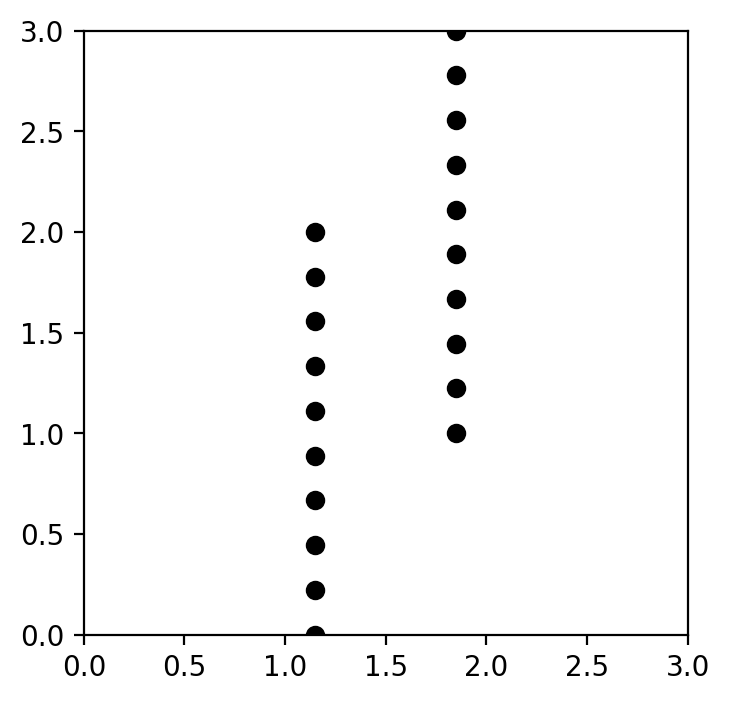

In [5]:
prepare_figure()
plot_obstacle_points()

In [12]:
def is_collision(test_positions):
    distances = np.linalg.norm(test_positions[None] - obstacle_points[:, None], axis=2)
    result = np.any(distances < radius, axis=0)
    result |= test_positions[:, 0] > 3
    result |= test_positions[:, 0] < 0
    result |= test_positions[:, 1] > 3
    result |= test_positions[:, 1] < 0
    return result

In [13]:
positions = np.random.rand(100, 2) * 3
collision = is_collision(positions)

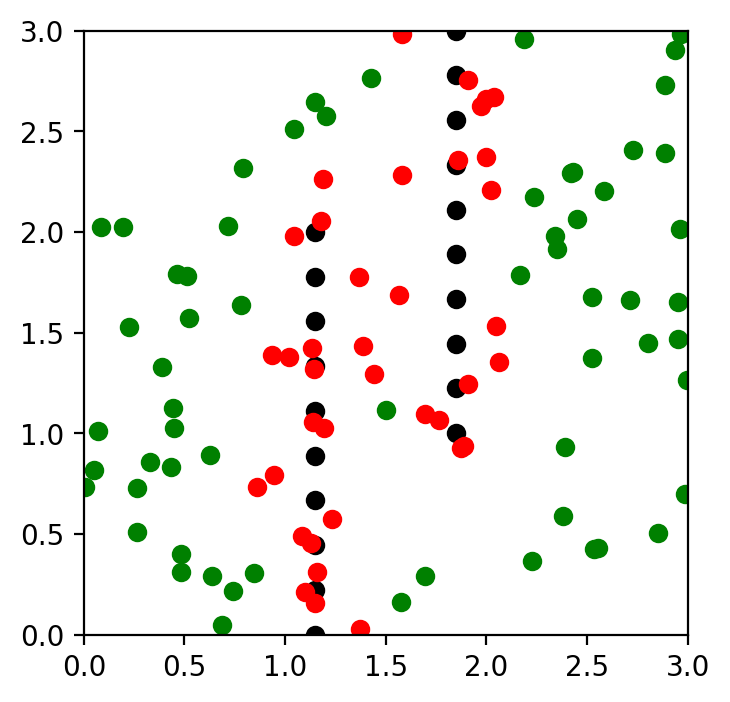

In [14]:
prepare_figure()
plot_obstacle_points()
plt.scatter(positions[collision, 0], positions[collision, 1], color="red")
plt.scatter(positions[~collision, 0], positions[~collision, 1], color="green")

# Obstacle neural field model

In [99]:
class ONF(nn.Module):
    def __init__(self):
        super().__init__()
        self.mlp = nn.Sequential(*[
            nn.Linear(10, 100),
            nn.ReLU(),
#             nn.Linear(100, 100),
#             nn.ReLU(),
            nn.Linear(100, 1)
        ])
        
        self.encoding_layer = nn.Linear(2, 10, bias=False)
#         self.encoding_layer.data.requires_grad_(False)

    def forward(self, x):
        x = (x - 1.5) / 3
        x = self.encoding_layer(x)
        x = torch.sin_(x)
        x = self.mlp(x)
        return x

In [100]:
model = ONF()
loss_function = nn.BCEWithLogitsLoss()
optimizer = torch.optim.Adam(model.parameters(), 5e-2)
for i in range(200):
    optimizer.zero_grad()
    positions = np.random.rand(100, 2) * 3
    collision = is_collision(positions)
    x = model(torch.tensor(positions.astype(np.float32)))
    loss = loss_function(x, torch.tensor(collision.astype(np.float32)[:, None]))
    loss.backward()
    optimizer.step()

In [101]:
def plot_model_heatmap(model):
    grid_x, grid_y = np.meshgrid(np.linspace(0, 3, 100), np.linspace(0, 3, 100))
    grid = np.stack([grid_x, grid_y], axis=2).reshape(-1, 2)
    obstacle_probabilites = nn.functional.softplus(model(torch.tensor(grid.astype(np.float32))))
    obstacle_probabilites = obstacle_probabilites.cpu().detach().numpy().reshape(100, 100)
    grid = grid.reshape(100, 100, 2)
    plt.gca().pcolormesh(grid[:, :, 0], grid[:, :, 1], obstacle_probabilites, cmap='RdBu')

/tmp/ipykernel_811546/256273326.py:7: MatplotlibDeprecationWarning: shading='flat' when X and Y have the same dimensions as C is deprecated since 3.3.  Either specify the corners of the quadrilaterals with X and Y, or pass shading='auto', 'nearest' or 'gouraud', or set rcParams['pcolor.shading'].  This will become an error two minor releases later.
  plt.gca().pcolormesh(grid[:, :, 0], grid[:, :, 1], obstacle_probabilites, cmap='RdBu')


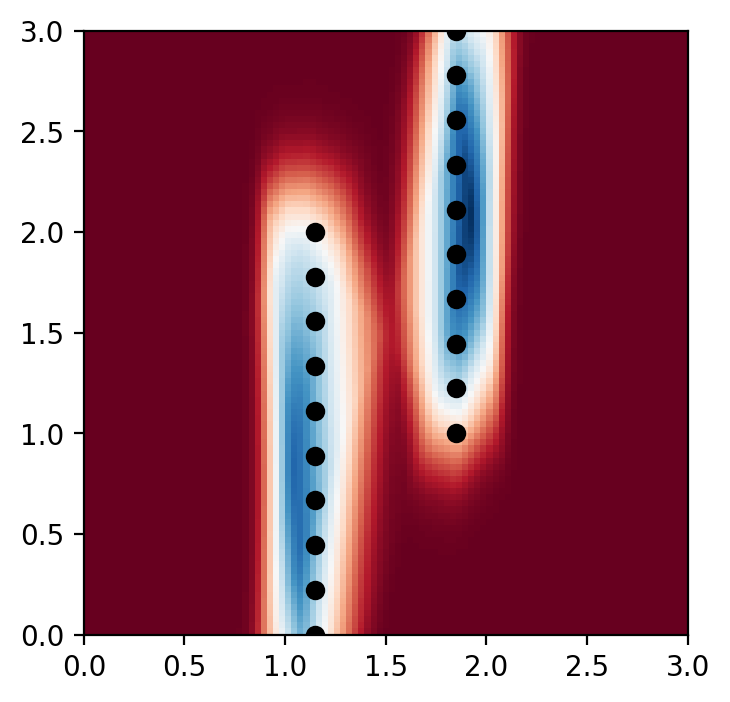

In [102]:
prepare_figure()
plot_model_heatmap(model)
plot_obstacle_points()

# Planner

In [103]:
goal_point = np.array([2.5, 2.5, 0])
point_count = 100
start_point = np.array([0.5, 0.5, 0])

simple_trajectory = np.zeros((point_count + 2, 3))
simple_trajectory[:, 0] = np.linspace(start_point[0], goal_point[0], point_count + 2)
simple_trajectory[:, 1] = np.linspace(start_point[1], goal_point[1], point_count + 2)
simple_trajectory[:, 2] = np.linspace(start_point[2], goal_point[2], point_count + 2)

In [382]:
def wrap_angle(angles):
    return (angles + np.pi) % (2 * np.pi) - np.pi

def loss_function(trajectory):
    return distance_loss(trajectory) + 200 * constraint_loss(trajectory)

def distance_loss(trajectory):
    full_trajectory = torch.cat(
        [torch.tensor(start_point)[None], trajectory, torch.tensor(goal_point)[None]], dim=0)
    delta = full_trajectory[1:] - full_trajectory[:-1]
    delta_angles = delta[:, 2]
    delta_angles = wrap_angle(delta_angles)
    angle_sum = torch.sum(delta_angles.detach()) - full_trajectory[-1, 2] + full_trajectory[0, 2]
    delta[-1, 2] += angle_sum
    delta[:, 2] *= 0.2
    return torch.sum(delta ** 2)

def constraint_deltas(trajectory):
    full_trajectory = torch.cat(
        [torch.tensor(start_point)[None], trajectory, torch.tensor(goal_point)[None]], dim=0)
    dx = full_trajectory[1:, 0] - full_trajectory[:-1, 0]
    dy = full_trajectory[1:, 1] - full_trajectory[:-1, 1]
    angles = full_trajectory[:, 2]
    delta_angles = wrap_angle(angles[:-1] - angles[1:])
    mean_angles = angles[:-1] + delta_angles / 2
    norm = torch.sqrt(dx ** 2 + dy ** 2 + 1e-12)
    return (dx * torch.sin(mean_angles) - dy * torch.cos(mean_angles))

def collision_loss(trajectory, model):
    collision_probabilities = model(trajectory[:, :2])
    collision_probabilities = nn.functional.softplus(collision_probabilities)
    return torch.sum(collision_probabilities)

def border_loss(trajectory):
#     trajectory = 2 * trajectory
    loss = torch.exp(-trajectory[:, 0])
    loss = loss + torch.exp(-3 + trajectory[:, 0])
    loss = loss + torch.exp(-trajectory[:, 1])
    loss = loss + torch.exp(-3 + trajectory[:, 1])
    return torch.sum(loss)

def random_middle_points(trajectory):
    t = torch.tensor(np.random.rand(trajectory.shape[0] - 1).astype(np.float32))[:, None]
    return trajectory[1:] * (1 - t) + trajectory[:-1] * t

In [383]:
hessian = np.zeros((point_count, point_count), dtype=np.float32)
for i in range(point_count):
    hessian[i, i] = 4 + 1.
    if i > 0:
        hessian[i, i - 1] = -2
        hessian[i - 1, i] = -2
inv_hessian = torch.tensor(np.linalg.inv(hessian))

In [408]:
trajectory = torch.tensor(simple_trajectory[1:-1].astype(np.float32), requires_grad=True)
# trajectory = torch.tensor(np.random.rand(100, 3).astype(np.float32) * 3, requires_grad=True)
optimizer = torch.optim.Adam([trajectory], lr=2e-3)
loss_function = nn.BCEWithLogitsLoss()
collision_model = copy.deepcopy(model)
collision_optimizer = torch.optim.Adam(collision_model.parameters(), 1e-1)
np.random.seed(201)
multipliers = torch.zeros(point_count + 1, requires_grad=True)

for i in range(20000):
    collision_model.requires_grad_(True)
    points = random_middle_points(trajectory)
    collision_optimizer.zero_grad()
    positions = points.detach().cpu().numpy()[:, :2] + np.random.rand(99, 2) * 0.01
    positions = np.concatenate([positions, np.random.rand(10, 2) * 3], axis=0)
    collision = is_collision(positions)
    x = collision_model(torch.tensor(positions.astype(np.float32)))
    loss = loss_function(x, torch.tensor(collision.astype(np.float32)[:, None]))
    loss.backward()
    collision_optimizer.step()
    
    collision_model.requires_grad_(False)
    optimizer.zero_grad()
    loss = distance_loss(trajectory) + collision_loss(points, collision_model) / 2 +\
        torch.sum(multipliers * constraint_deltas(trajectory)) #+ border_loss(trajectory) / 1000
    loss.backward()
    trajectory.grad = inv_hessian @ trajectory.grad
    optimizer.step()
    
    multipliers.data.add_(1e-1 * multipliers.grad.detach())
    multipliers.grad.data.zero_()
print(loss.item())

0.6717600007230765


In [409]:
collision_probabilities = collision_model(trajectory[:, :2])
collision_probabilities = nn.functional.softplus(collision_probabilities)
collision_loss(trajectory, collision_model)
border_loss(trajectory) / 100

tensor(1.1009, grad_fn=<DivBackward0>)

In [410]:
optimizer.zero_grad()
loss = distance_loss(trajectory) + collision_loss(trajectory, collision_model) / 2 +\
        torch.sum(multipliers * constraint_deltas(trajectory)) #+ border_loss(trajectory) / 20
# loss = collision_loss(trajectory, collision_model)
loss.backward()
gradients = -trajectory.grad.data.cpu().numpy()
gradients = inv_hessian @ gradients

/tmp/ipykernel_811546/256273326.py:7: MatplotlibDeprecationWarning: shading='flat' when X and Y have the same dimensions as C is deprecated since 3.3.  Either specify the corners of the quadrilaterals with X and Y, or pass shading='auto', 'nearest' or 'gouraud', or set rcParams['pcolor.shading'].  This will become an error two minor releases later.
  plt.gca().pcolormesh(grid[:, :, 0], grid[:, :, 1], obstacle_probabilites, cmap='RdBu')


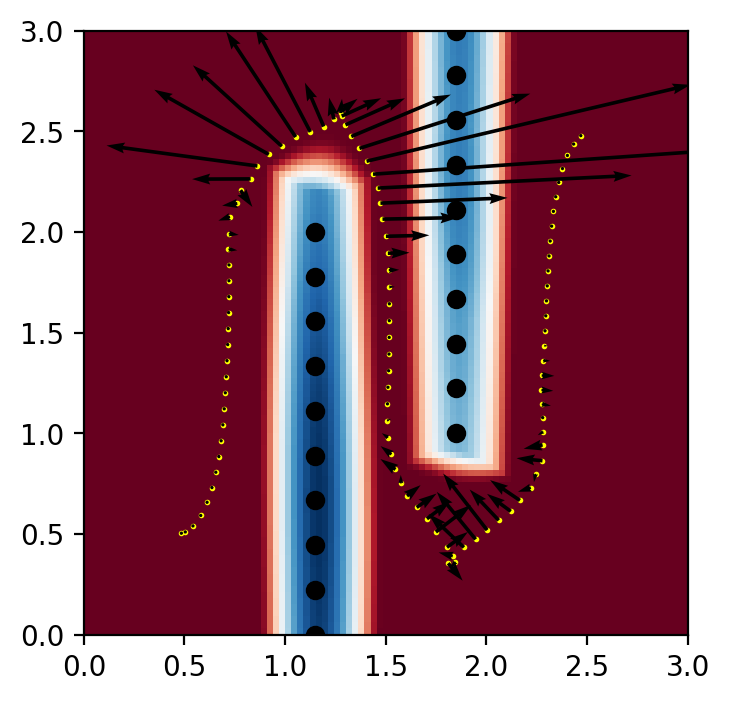

In [411]:
prepare_figure()
plotted_trajectory = trajectory.cpu().detach().numpy()
plot_model_heatmap(collision_model)
plot_obstacle_points()
plt.scatter(plotted_trajectory[:, 0], plotted_trajectory[:, 1], color="yellow", s=1)
plt.quiver(plotted_trajectory[:, 0], plotted_trajectory[:, 1], gradients[:, 0], gradients[:, 1])